<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/GoingDeeper/GoingDeeper_NLP16_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 커스텀 프로젝트 만들기

In [ ]:
#!pip install tensorflow-datasets -U

In [ ]:
# ! cd ~/content && git clone https://github.com/huggingface/transformers.git
# ! cd transformers && pip install -e .
# ! pip install datasets
# ! pip install huggingface-hub==0.1.0

In [ ]:
# ! pip3 install transformers

In [1]:
import os
import numpy as np
from argparse import ArgumentParser
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures
from transformers import pipeline, RobertaTokenizer, TFRobertaModel


## 1. mnli 데이터셋을 분석해 보기

In [2]:
data, info = tfds.load('glue/mnli', with_info=True)
info.splits['train'].num_examples

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/5 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/392702 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteCW4AKH/glue-train.tfrecord*...:   0%|          |…

Generating validation_matched examples...:   0%|          | 0/9815 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteCW4AKH/glue-validation_matched.tfrecord*...:   0…

Generating validation_mismatched examples...:   0%|          | 0/9832 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteCW4AKH/glue-validation_mismatched.tfrecord*...: …

Generating test_matched examples...:   0%|          | 0/9796 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteCW4AKH/glue-test_matched.tfrecord*...:   0%|    …

Generating test_mismatched examples...:   0%|          | 0/9847 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteCW4AKH/glue-test_mismatched.tfrecord*...:   0%| …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mnli/2.0.0. Subsequent calls will reuse this data.


392702

In [3]:
data['train'].take(1)

<TakeDataset element_spec={'hypothesis': TensorSpec(shape=(), dtype=tf.string, name=None), 'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'premise': TensorSpec(shape=(), dtype=tf.string, name=None)}>

## 2. MnliProcessor 클래스 구현하기

In [4]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

print("슝~")

슝~


In [5]:
class MnliProcessor(DataProcessor):
    """Processor for the MultiNLI data set (GLUE version)."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["premise"].numpy().decode("utf-8"),
            tensor_dict["hypothesis"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev_matched.tsv")), "dev_matched")

    def get_labels(self):
        """See base class."""
        return ["contradiction", "entailment", "neutral"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, line[0])
            text_a = line[8]
            text_b = line[9]
            label = line[-1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

## 3. 데이터셋 구성하기

In [6]:
processor = MnliProcessor()
examples = data['train'].take(1)

for example in examples:
    print('------원본데이터------')
    print(example)  
    example = processor.get_example_from_tensor_dict(example)
    print('------processor 가공데이터------')
    print(example)

------원본데이터------
{'hypothesis': <tf.Tensor: shape=(), dtype=string, numpy=b'Meaningful partnerships with stakeholders is crucial.'>, 'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'premise': <tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>}
------processor 가공데이터------
InputExample(guid=16399, text_a='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', text_b='Meaningful partnerships with stakeh

In [7]:
from transformers import ElectraForPreTraining, ElectraTokenizerFast

# tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
# model = TFRobertaModel.from_pretrained('roberta-large')

discriminator = ElectraForPreTraining.from_pretrained("google/electra-base-discriminator")
tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator")

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        print("*** Example ***")
        print("guid: %s" % (example.guid))
        print("features: %s" % features[i])

    return features

In [9]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

In [10]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=32, processor=processor)

Using label list ['contradiction', 'entailment', 'neutral']
*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 1999, 5038, 1997, 2122, 13136, 1010, 1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, 10908, 1997, 1996, 2110, 102, 15902, 13797, 2007, 22859, 2003, 10232, 1012, 102], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], label=1)
*** Example ***
guid: 206287
features: InputFeatures(input_ids=[101, 1996, 7207, 7505, 21799, 2015, 2036, 2218, 1996, 2152, 2598, 1999, 1996, 6123, 2162, 1012, 102, 1996, 7207, 8771, 2921, 2000, 1996, 3020, 2598, 1999, 1996, 6594, 1012, 102, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 

In [11]:
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

In [14]:
# validation 데이터셋
validation_dataset = tf_glue_convert_examples_to_features(data['validation_matched'], tokenizer, max_length=32, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['contradiction', 'entailment', 'neutral']
*** Example ***
guid: 6287
features: InputFeatures(input_ids=[101, 7910, 1011, 9616, 2821, 3398, 2035, 1996, 2111, 2005, 2157, 7910, 2166, 2030, 2242, 102, 3398, 7167, 1997, 2111, 2005, 1996, 2157, 2166, 102, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], label=0)
*** Example ***
guid: 1579
features: InputFeatures(input_ids=[101, 2036, 1010, 1045, 2097, 2022, 10262, 2008, 1996, 1020, 1012, 1014, 2050, 3465, 1997, 1996, 102, 1045, 2097, 2022, 10262, 2008, 1996, 1020, 1012, 1014, 2050, 3465, 1997, 1996, 10690, 102], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [15]:
# test 데이터셋
test_dataset = tf_glue_convert_examples_to_features(data['test_matched'], tokenizer, max_length=32, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['contradiction', 'entailment', 'neutral']
*** Example ***
guid: 5398
features: InputFeatures(input_ids=[101, 2092, 2003, 2045, 1037, 2210, 3751, 10216, 2017, 2404, 1999, 2045, 102, 2003, 2045, 1037, 10216, 2008, 2017, 2404, 1999, 2045, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], label=2)
*** Example ***
guid: 1921
features: InputFeatures(input_ids=[101, 1996, 13410, 2139, 6517, 2063, 1005, 1055, 2132, 2003, 2124, 2000, 2022, 2682, 2598, 1010, 2004, 102, 1996, 13410, 2139, 6517, 2063, 1005, 1055, 2132, 2003, 9689, 2921, 5230, 1012, 102], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# 4. 모델 학습하기

In [16]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

이걸 어떻게 학습시키는지 모르겠다. 검색해도 안나온다..  
ROBERTa랑 ELECTRA로 시도해봤는데 잘 못하겠다.  

## 5. 회고
1. ROBERTa 토크나이저를 할때 뭐가 문제인지 무한루프를 돌았다. Huggingface에 적힌대로 모델이랑 토크나이저를 불러왔는데 무슨 이유인지 잘 모르겠지만 무한루프를 돌아서 뻗어버렸다. 학습시키는 건 할 수 따라할만한 게 있어서 시도해볼만 했는데 아쉽다.

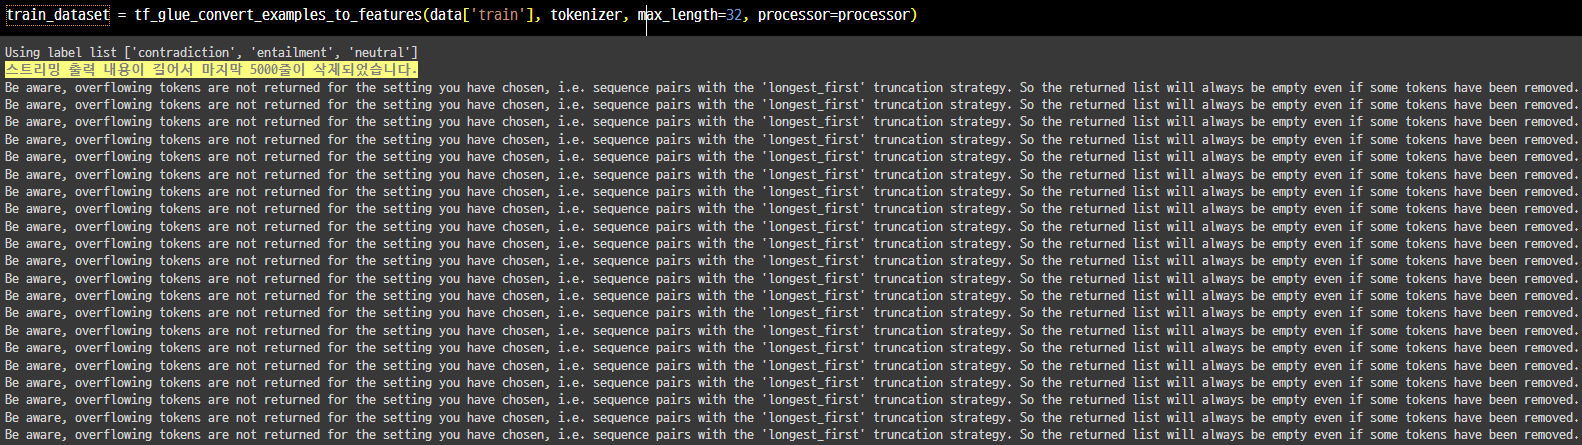

2. 아이펠톤에서 사용할 모델을 연습할겸 ELCETRA를 사용해보려고 했는데 ELCETRA는 discriminator를 이용한 학습방법을 사용하는 것 같았다. 아이펠톤 준비를 위해 고잉디퍼는 여기에서 접어두고 통상적인 허깅페이스 모델 사용방법을 알아보는 것이 좋을것 같다.. 중간에 아프지만 않았어도 붙잡고 있을 시간이 있었을텐데 아쉽다.